### Third Step

Consider the case in which the bid is fixed and learn in online fashion the best pricing strategy when the algorithm does not discriminate among the customers’ classes (and therefore the algorithm works with aggregate data). Assume that the number of daily clicks and the daily cost per click are known. Adopt both an upper-confidence bound approach and a Thompson-sampling approach and compare their performance.

In [13]:
import numpy as np

# Abstract-Super class of Learner
class Learner():
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.price = np.linspace(3.0, 15.0, self.n_arms) 
        self.t = 0  #Time 
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = []
    
    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards.append(reward)

##################################   LEARNERS    ##################################
# Thompson-Sampling Learner

class TS_Learner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        #Mean and Std
        self.normal_parameters = np.zeros((self.n_arms, 2))

    def pull_arm(self):
        if self.t < self.n_arms: return self.t
        return np.argmax(np.random.normal(self.normal_parameters[: , 0], self.normal_parameters[:, 1]))

    def update(self, pulled_arm, reward):
        self.t += 1
        times_pulled = max(1, len(self.rewards_per_arm[pulled_arm]))
        self.update_observations(pulled_arm, reward)
        #Empirical mean
        self.normal_parameters[pulled_arm, 0] = (self.normal_parameters[pulled_arm, 0] * (times_pulled - 1) + reward ) / times_pulled
        #Empirical std
        self.normal_parameters[pulled_arm, 1] = np.sqrt(sum((self.normal_parameters[pulled_arm, 0] - self.rewards_per_arm[pulled_arm])**2)/times_pulled)

# Upper-Confidence Bound Learner
class UCB1(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.zeros(n_arms)

    def pull_arm(self):
        if self.t < self.n_arms:
            return self.t 
        upper_bound = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    
    def update(self, pulled_arm, reward):
        self.t += 1
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards.append(reward)
        self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm] * (self.t-1) + reward)/self.t
        for a in range(self.n_arms):
            number_pulled = max(1, len(self.rewards_per_arm[a]) ) 
            self.confidence[a] = (2*np.log(self.t) /number_pulled)**0.5

### Main for the experiment

In [24]:
from environment import Environment
from tqdm import tqdm

env = Environment()
n_arms = 13
ucb1_learner = UCB1(n_arms = n_arms)
ts_learner = TS_Learner(n_arms = n_arms)

T = 365
opt_bids = [3.9416202240277745 , 3.0,  4.0]
opt_price = 7
regret_ucb = []
regret_ts = []

# Use this for testing, the price learned is 7, the optimal one
# bids = opt_bids 
bids = [5.0, 5.0, 5.0]
prices = np.linspace(3.0, 15.0, n_arms)

price_ev_per_day_ucb = []
price_ev_per_day_ts = []

for day in range(T):
    #UCB1 learner
    price_idx = ucb1_learner.pull_arm()
    price = prices[price_idx]
    reward = sum(env.round(bids, price)) #treat as aggregate data
    ucb1_learner.update(price_idx, reward)
    regret_ucb.append(sum(env.round(opt_bids, opt_price, noise= False)) - reward)
    price_ev_per_day_ucb.append(price)

    #TS learner
    price_idx = ts_learner.pull_arm()
    price = prices[price_idx]
    reward = sum(env.round(bids, price)) #treat as aggregate data
    ts_learner.update(price_idx, reward)
    regret_ts.append(sum(env.round(opt_bids, opt_price, noise= False)) - reward)
    price_ev_per_day_ts.append(price)


### Plots

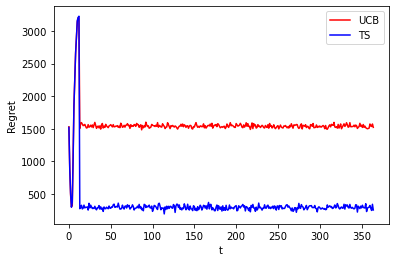

In [25]:
import matplotlib.pyplot as plt 

plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(regret_ucb , 'r')
plt.plot(regret_ts, "b")
plt.legend(["UCB", "TS"])
plt.show()

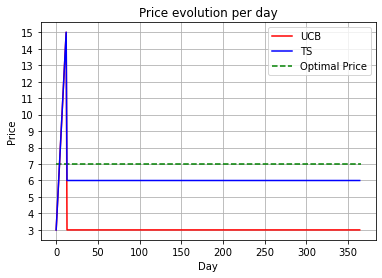

In [41]:
import matplotlib.pyplot as plt 

plt.figure(1)
plt.xlabel("Day")
plt.ylabel("Price")
plt.plot(price_ev_per_day_ucb , 'r')
plt.plot(price_ev_per_day_ts , 'b')
plt.grid()
plt.yticks(prices)
plt.hlines(opt_price, 0, 365, 'g', linestyles='dashed', label="optimal price")
plt.legend(["UCB", "TS", "Optimal Price"])
plt.title("Price evolution per day")
plt.show()